# Race and Median Income

This is a deeper local analysis of some of the data from an [NJISJ report](https://njisj.org/reports/stateofinequity/) on Essex County
as reported in an [NJ Patch](https://patch.com/new-jersey/maplewood/s/iv2ag/essex-county-has-some-of-worst-racial-wealth-gaps-in-new-jersey-study?utm_source=local-update&utm_medium=email&utm_campaign=alert) article.

## Imports, Definitions, and Setup

In [1]:
from typing import List, Iterable

import censusdis.data as ced

from censusdis.datasets import ACS5

from censusdis.states import NJ
from censusdis.counties.new_jersey import (
    ESSEX,
    MONMOUTH,
    PASSAIC,
    MERCER,
    HUDSON,
    UNION,
    SOMERSET,
    MORRIS,
)

import pandas as pd
from matplotlib.ticker import FuncFormatter, PercentFormatter

In [2]:
MHI_WHITE = "B19013H_001E"
MHI_BLACK = "B19013B_001E"
MHI_HISPANIC_LATINO = "B19013I_001E"

VARIABLES = {
    MHI_WHITE: "White",
    MHI_BLACK: "Black",
    MHI_HISPANIC_LATINO: "Latina/o",
}

In [3]:
def data_for(**kwargs) -> pd.DataFrame:
    df = ced.download(
        dataset=ACS5,
        vintage=2022,
        download_variables=["NAME"] + list(VARIABLES.keys()),
        **kwargs,
    )

    df.rename(VARIABLES, axis="columns", inplace=True)

    return df


def add_diffs(df: pd.DataFrame) -> pd.DataFrame:
    for var, name in VARIABLES.items():
        if var != MHI_WHITE:
            df[f"{name} White Gap"] = df[VARIABLES[MHI_WHITE]] - df[name]
    return df

## Fetch County-Level Data

In [4]:
df_county = data_for(state=NJ, county="*")

In [5]:
add_diffs(df_county)

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
0,34,001,"Atlantic County, New Jersey",86136,49658,50186,36478,35950
1,34,003,"Bergen County, New Jersey",126191,88587,90934,37604,35257
2,34,005,"Burlington County, New Jersey",106552,86391,85321,20161,21231
3,34,007,"Camden County, New Jersey",98984,55821,53993,43163,44991
4,34,009,"Cape May County, New Jersey",86285,41014,69381,45271,16904
5,34,011,"Cumberland County, New Jersey",78625,41250,51968,37375,26657
6,34,013,"Essex County, New Jersey",125107,54727,60235,70380,64872
7,34,015,"Gloucester County, New Jersey",103750,71010,82855,32740,20895
8,34,017,"Hudson County, New Jersey",113851,63023,63420,50828,50431
9,34,019,"Hunterdon County, New Jersey",132989,118125,122371,14864,10618


## Compare to NJISJ Numbers

### NJISJ Figure 4

In [6]:
def white_vs(df: pd.DataFrame, counties: List[str], vs: str):
    df = pd.DataFrame(df[["COUNTY", "NAME", f"{VARIABLES[vs]} White Gap"]])

    df = df[df["COUNTY"].isin(counties)]

    county_order = {county: ii for ii, county in enumerate(counties)}

    df["ii"] = df["COUNTY"].apply(lambda c: county_order.get(c, -1))

    df.sort_values(by="ii", inplace=True)

    df.drop("ii", axis="columns", inplace=True)

    return df

In [7]:
white_vs(df_county, [ESSEX, MONMOUTH, PASSAIC, MERCER, HUDSON], MHI_BLACK)

,COUNTY,NAME,Black White Gap
6,013,"Essex County, New Jersey",70380
12,025,"Monmouth County, New Jersey",60068
15,031,"Passaic County, New Jersey",58524
10,021,"Mercer County, New Jersey",51872
8,017,"Hudson County, New Jersey",50828


In [8]:
white_vs(df_county, [ESSEX, UNION, HUDSON, SOMERSET, MORRIS], MHI_HISPANIC_LATINO)

,COUNTY,NAME,Latina/o White Gap
6,013,"Essex County, New Jersey",64872
19,039,"Union County, New Jersey",55898
8,017,"Hudson County, New Jersey",50431
17,035,"Somerset County, New Jersey",47355
13,027,"Morris County, New Jersey",46241


In [9]:
def plot_white_vs(df: pd.DataFrame, counties: Iterable[str], vs: str, title: str):

    counties = list(counties)

    gap_col = f"{VARIABLES[vs]} {VARIABLES[MHI_WHITE]} Gap"

    df_county_plot = pd.DataFrame(
        df[["COUNTY", VARIABLES[MHI_WHITE], VARIABLES[vs], gap_col]]
    )
    df_county_plot.index = df["NAME"].map(lambda name: name.split(",")[0])

    df_county_plot = df_county_plot[df_county_plot["COUNTY"].isin(counties)]

    county_order = {county: ii for ii, county in enumerate(counties)}

    df_county_plot["ii"] = df_county_plot["COUNTY"].apply(
        lambda c: county_order.get(c, -1)
    )

    df_county_plot.sort_values(by="ii", inplace=True)

    df_county_plot.drop("ii", axis="columns", inplace=True)

    print(df_county_plot.columns)

    ax = df_county_plot[["COUNTY", VARIABLES[MHI_WHITE], VARIABLES[vs]]].plot.bar(
        figsize=(10, 6)
    )

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"${x:,.0f}"))
    ax.yaxis.grid()

    ax.set_ylim(0, 140_000)

    ax.set_xticklabels(
        [
            f"{c}\n(${df_county_plot.loc[c][gap_col]:,.0f})"
            for c in df_county_plot.index
        ],
        rotation=45,
    )

    ax.set_ylabel("Median Household Income")
    ax.set_xlabel("County\n(Income Gap)")
    ax.set_title(title)

    return ax

Index(['COUNTY', 'White', 'Black', 'Black White Gap'], dtype='object')


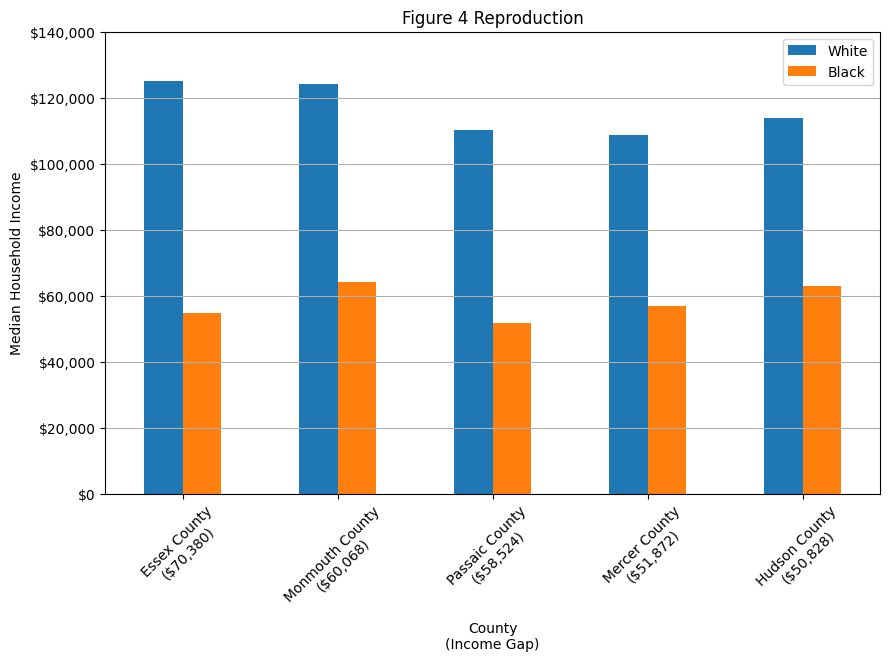

In [10]:
ax = plot_white_vs(
    df_county,
    [ESSEX, MONMOUTH, PASSAIC, MERCER, HUDSON],
    MHI_BLACK,
    "Figure 4 Reproduction",
)

### NJISJ Figure 5

Index(['COUNTY', 'White', 'Latina/o', 'Latina/o White Gap'], dtype='object')


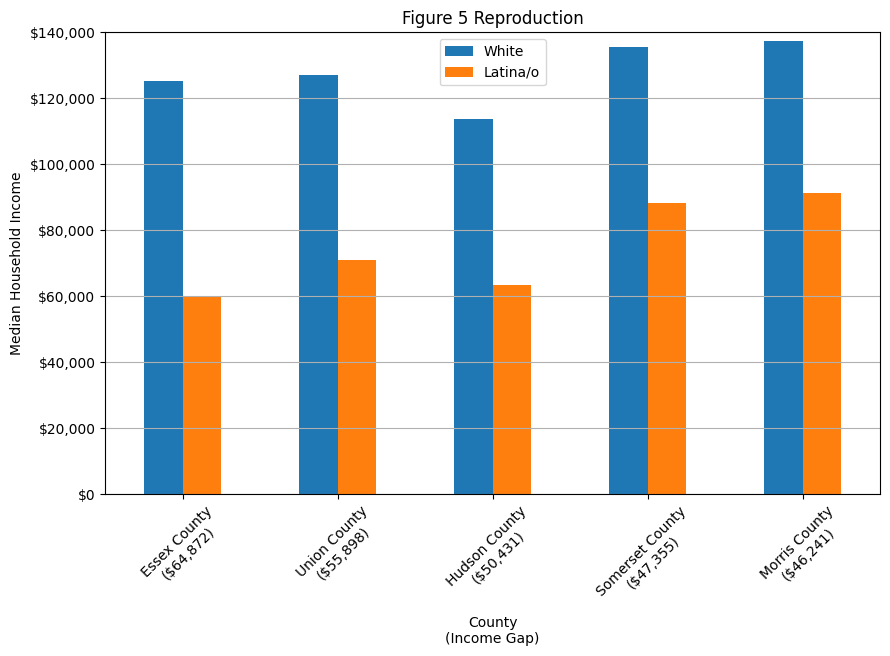

In [11]:
ax = plot_white_vs(
    df_county,
    [ESSEX, UNION, HUDSON, SOMERSET, MORRIS],
    MHI_HISPANIC_LATINO,
    "Figure 5 Reproduction",
)

### Are the Top Five Right?

In [12]:
def order_by_gap(df: pd.DataFrame, vs: str) -> pd.DataFrame:
    df = df.sort_values(by=f"{VARIABLES[vs]} White Gap", ascending=False)

    return df

In [13]:
df_order_black = order_by_gap(df_county, MHI_BLACK)
df_order_hispanic_latino = order_by_gap(df_county, MHI_HISPANIC_LATINO)

In [14]:
df_order_black.head(5)

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
6,34,013,"Essex County, New Jersey",125107,54727,60235,70380,64872
12,34,025,"Monmouth County, New Jersey",124071,64003,90889,60068,33182
15,34,031,"Passaic County, New Jersey",110267,51743,64167,58524,46100
10,34,021,"Mercer County, New Jersey",108700,56828,72250,51872,36450
8,34,017,"Hudson County, New Jersey",113851,63023,63420,50828,50431


In [15]:
df_order_hispanic_latino.head(5)

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
6,34,013,"Essex County, New Jersey",125107,54727,60235,70380,64872
19,34,039,"Union County, New Jersey",127001,81578,71103,45423,55898
8,34,017,"Hudson County, New Jersey",113851,63023,63420,50828,50431
17,34,035,"Somerset County, New Jersey",135664,100730,88309,34934,47355
13,34,027,"Morris County, New Jersey",137409,89511,91168,47898,46241


### Validated Top Five Plots

We reproduce NJISJ figures 4 and 5 using the top five we computed.

Index(['COUNTY', 'White', 'Black', 'Black White Gap'], dtype='object')


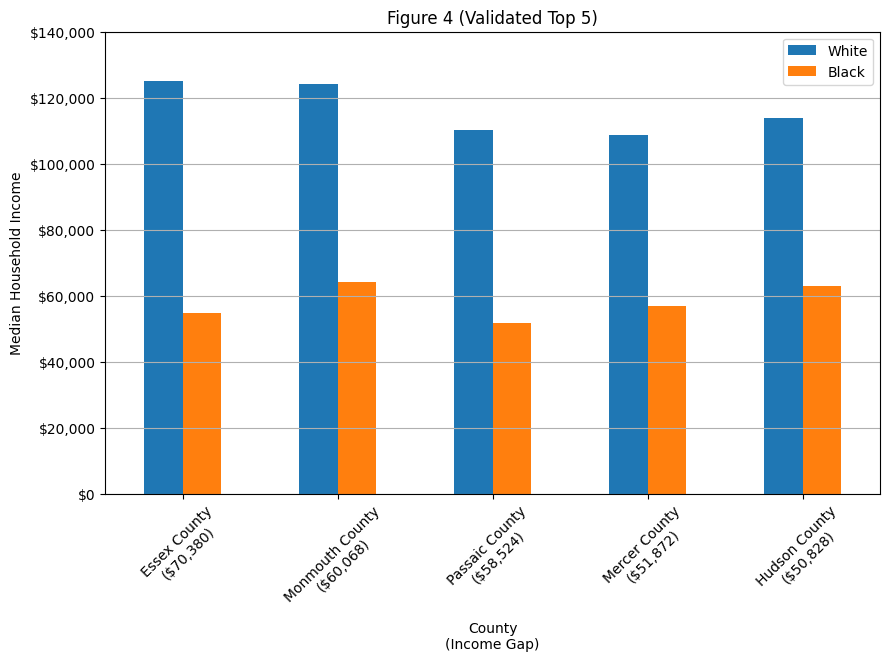

In [16]:
df_top_black_gap = df_order_black.head(5)

ax = plot_white_vs(
    df_top_black_gap,
    df_top_black_gap["COUNTY"],
    MHI_BLACK,
    "Figure 4 (Validated Top 5)",
)

Index(['COUNTY', 'White', 'Latina/o', 'Latina/o White Gap'], dtype='object')


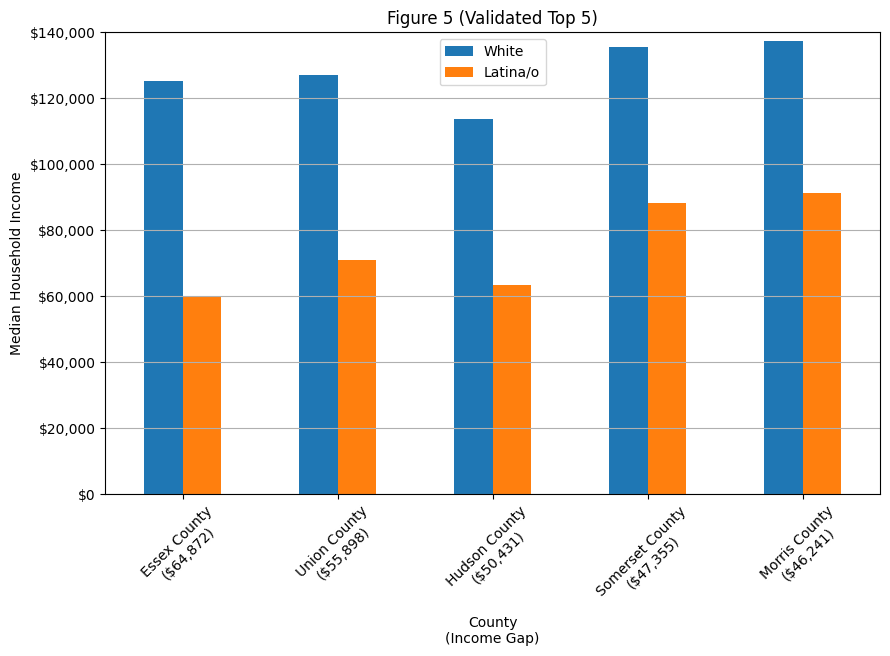

In [17]:
df_top_hispanic_latino_gap = df_order_hispanic_latino.head(5)

ax = plot_white_vs(
    df_top_hispanic_latino_gap,
    df_top_hispanic_latino_gap["COUNTY"],
    MHI_HISPANIC_LATINO,
    "Figure 5 (Validated Top 5)",
)

### Are the Bottom Five Right?

In [18]:
df_order_black.tail(5)

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
14,34,029,"Ocean County, New Jersey",82688,64306,80660,18382,2028
9,34,019,"Hunterdon County, New Jersey",132989,118125,122371,14864,10618
11,34,023,"Middlesex County, New Jersey",102638,90049,77774,12589,24864
20,34,041,"Warren County, New Jersey",93596,91692,82612,1904,10984
18,34,037,"Sussex County, New Jersey",110607,134810,101243,-24203,9364


In [19]:
df_order_hispanic_latino.tail(5)

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
4,34,009,"Cape May County, New Jersey",86285,41014,69381,45271,16904
20,34,041,"Warren County, New Jersey",93596,91692,82612,1904,10984
9,34,019,"Hunterdon County, New Jersey",132989,118125,122371,14864,10618
18,34,037,"Sussex County, New Jersey",110607,134810,101243,-24203,9364
14,34,029,"Ocean County, New Jersey",82688,64306,80660,18382,2028


Index(['COUNTY', 'White', 'Black', 'Black White Gap'], dtype='object')


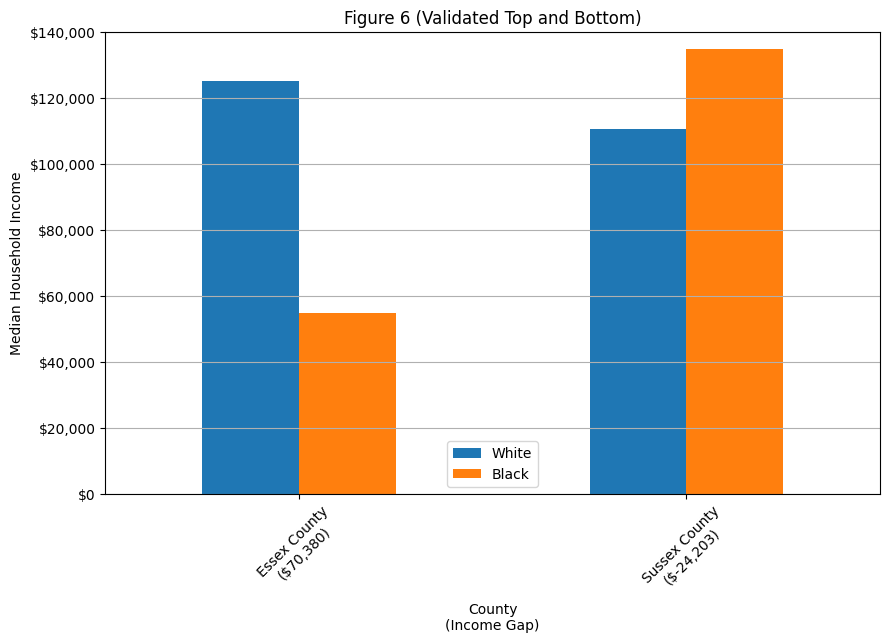

In [20]:
df_top_bottom_black = pd.concat([df_order_black.head(1), df_order_black.tail(1)])

_ = plot_white_vs(
    df_top_bottom_black,
    df_top_bottom_black["COUNTY"],
    MHI_BLACK,
    "Figure 6 (Validated Top and Bottom)",
)

Index(['COUNTY', 'White', 'Black', 'Black White Gap'], dtype='object')


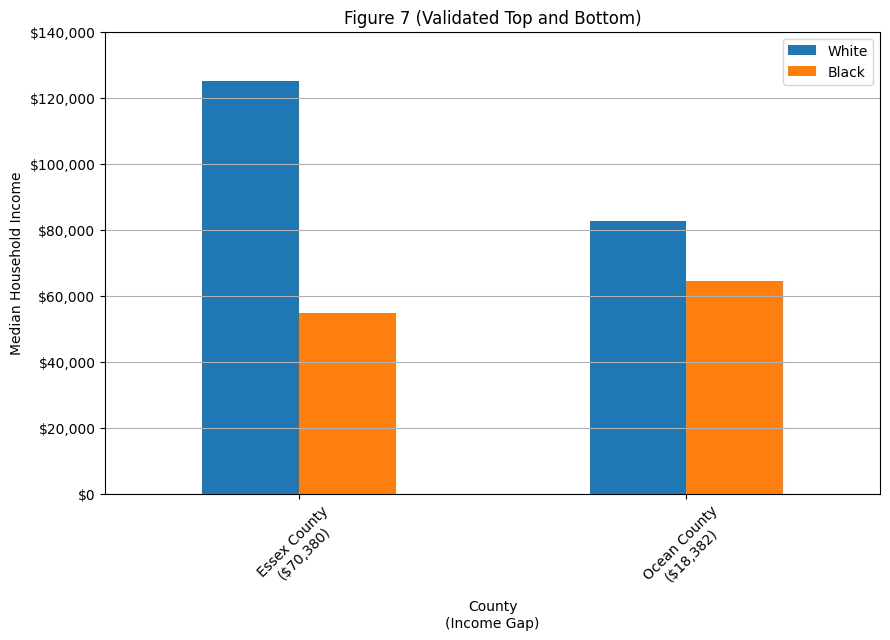

In [21]:
df_top_bottom_hispanic_latino = pd.concat(
    [df_order_hispanic_latino.head(1), df_order_hispanic_latino.tail(1)]
)

_ = plot_white_vs(
    df_top_bottom_hispanic_latino,
    df_top_bottom_hispanic_latino["COUNTY"],
    MHI_BLACK,
    "Figure 7 (Validated Top and Bottom)",
)

## SoMa

In [22]:
df_soma = data_for(zip_code_tabulation_area=["07079", "07040"])
add_diffs(df_soma)

,ZIP_CODE_TABULATION_AREA,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
0,07040,ZCTA5 07040,229839,102930,137092,126909,92747
1,07079,ZCTA5 07079,186467,139292,160357,47175,26110


## Save a CSV

In [23]:
df_csv = pd.concat([df_county, df_soma])[
    [col for col in df_county.columns if col not in ["STATE", "COUNTY"]]
]

In [24]:
df_csv

,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
0,"Atlantic County, New Jersey",86136,49658,50186,36478,35950
1,"Bergen County, New Jersey",126191,88587,90934,37604,35257
2,"Burlington County, New Jersey",106552,86391,85321,20161,21231
3,"Camden County, New Jersey",98984,55821,53993,43163,44991
4,"Cape May County, New Jersey",86285,41014,69381,45271,16904
5,"Cumberland County, New Jersey",78625,41250,51968,37375,26657
6,"Essex County, New Jersey",125107,54727,60235,70380,64872
7,"Gloucester County, New Jersey",103750,71010,82855,32740,20895
8,"Hudson County, New Jersey",113851,63023,63420,50828,50431
9,"Hunterdon County, New Jersey",132989,118125,122371,14864,10618


In [25]:
df_csv.to_csv("income_gap.csv", index=False)